# Convolutional Neural Networks
The kind of neural network that we have seen so far are fully connected, that is each unit of a layer is connected through  weights to all the units in the following layer. If n is the number of units of the first layer, and m the is the number of units of the second layer, the connections, or weights, between the two layers are represented by a matrix of rank nm. The number of weights in a fully connected multilayer perceptron increases rapidly if we add more than few layers to our network. Another problem of a fully connected layer is that it is not translation invariant (see also the [dlwpt](../dlwpt/ch8/dl_with_pytorch_ch8_convolutions.ipynb) folder for more info). These two problems can be solved using a mathematical operation on the input data called [convolution](https://en.wikipedia.org/wiki/Convolution)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print("PyTorch version: %s"%torch.__version__)

NumPy version: 1.23.1
Pandas version: 1.4.3
PyTorch version: 1.13.0


## One-dimensional convolution
We start with a convolution in one dimension. Mathematically a convolution $f*g$ of two functions $f$ and $g$ is defined as

$$(f*g)(t) = \int_{-\infty}^{\infty}f(\tau)g(t - \tau)d\tau$$

We call the function $f$ the signal, and the function $g$ the kernel. We can consider a discrete convolution of an input array x and a weight array w for which the above formula can be translated to this

$$y = x*w$$

where for each component of $y$ we have

$$y[i] = \sum_{k=-\infty}^{\infty} x[i - k]w[k]$$

The signal $x$ usually is defined within an finite interval so we assume a zero value of the signal at the beginning and at the end of the array. This transformation is called padding. The padding can be of any length, one, two, or more. If $p$ represents the padding and $n$ the length of the signal's array $x$, then the total length of the padded signal is $n + 2p$. If $m$ represents the length of the kernel, then we can compute the convolution of the signal for each index

$$y[i] = \sum_{k=0}^{m-1} x[i + m - k]w[k]$$

The index of the signal goes from the rigth to the left, in the opposite direction of the kernel's index. We can get the same result with both indices going in the same direction, e.g. from left to right, by flipping one of the two array, for example the kernel array. We flip the kernel array by rotating its element to the left till the last elements is moved to the first place.

We compute the convolution of a signal with its index going from right to the left. We will repeat the computation by flipping the kernel array and then computing the convolution with both indices going from the left to the right. We use a padding p = 1, adding a zero to the beginning and to the end of the signal array, and a stride s = 2, moving the kernel over the signal by two elements each time we compute the convolution.

In [3]:
x = np.array([3, 2, 1, 7, 1, 2, 5, 4])
x_ = np.append(x, 0) 
x_pad = np.append(0, x_) # p = 1, so len(x_pad) = len(x) + 2
x_pad

array([0, 3, 2, 1, 7, 1, 2, 5, 4, 0])

We compute the convolution of the signal x with the kernel w with their indices going in opposite direction

In [4]:
w = np.array([0.5, 0.75, 1.0, 0.25])
m = len(w)
i = 0
s = 2 # stride
y = sum([x_pad[s * i + m - k] * w[k] for k in range(0, m)])
y

7.0

No we follow the other approach, by flipping the kernel array.

In [5]:
w_flip = w[::-1]
w_flip

array([0.25, 1.  , 0.75, 0.5 ])

With this approach we do not need padding so we can use the original signal vector. 

In [6]:
p = 0 # padding 
s = 2 # stride
i = 0
y = sum([x[s * i + p + k] * w_flip[k] for k in range(0, m)])
#y = sum([x_pad[s * i + p + k] * w_flip[k] for k in range(0, m)])
y

7.0

## Convolution arithmetic
The length of the output of a convolution depends on the size of the signal array n, the size of the kernel m, and also on the padding p and stride s according to the formula

$$o = \left\lfloor \frac{n + 2p - m}{s} \right\rfloor + 1$$

where we take the largest integer value of the fraction. NumPy implements three type of one-dimensional convolutions that differ for the size of the output.

In [7]:
def conv1d_valid(x, w):
    ##
    ## Implements a "valid" convolution with padding = 0
    ##
    w_rot = np.array(w[::-1])
    n = len(x)
    m = len(w)
    o = max(n, m) - min(n, m) + 1
    res = []
    for i in range(0, o):
        c = sum([x[i + k] * w_rot[k] for k in range(0, m)])
        res.append(c)
    return np.array(res)

In [8]:
print('Conv1d Implementation (with padding mode = valid) :', conv1d_valid(x, w))

Conv1d Implementation (with padding mode = valid) : [7.   7.25 9.   6.75 8.  ]


In [9]:
print('Numpy Results:', np.convolve(x, w, mode='valid')) 

Numpy Results: [7.   7.25 9.   6.75 8.  ]


## 2D convolutions
Implementing a 2D convolution is straightforward from the example we have seen about the 1D convolution. We have to follow the same rules also for the additional dimension. The discrete 2D convolution is represented by the formula

$$y[i, j] = \sum_{l=0}^{m-1} \sum_{k=0}^{m-1} x[i + m - k, j + m - l]w[k, l]$$

where we assume the kernel size to be (m, m). The 2D convolution operator is also implemented in [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) 

In [10]:
def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2 * p[0]
    n2 = X_orig.shape[1] + 2 * p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0] + X_orig.shape[0], p[1]:p[1] + X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - W_rot.shape[0]) / s[0]) + 1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - W_rot.shape[1])/s[1]) + 1, s[1]):
            X_sub = X_padded[i:i + W_rot.shape[0], j:j + W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

In [11]:
X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]
conv2d(X, W, p=(1, 1), s=(1, 1))

array([[11., 25., 32., 13.],
       [19., 25., 24., 13.],
       [13., 28., 25., 17.],
       [11., 17., 14.,  9.]])

We can use a convolution as a filter for images for example to highlight the edges of the objects in the image

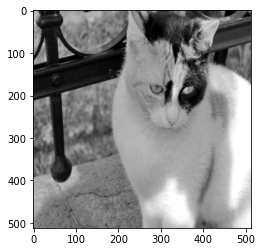

In [12]:
from skimage import io
from skimage.transform import resize
cat_img = io.imread('images/cat_dog_images/cat-01.jpg')[:,:,0] # use only one channel (red = 0, green = 1, blue = 2)
cat_img_resize = resize(cat_img, (512, 512))
plt.imshow(cat_img_resize, cmap='gray')

In [13]:
X = cat_img_resize
#W = [[1, 0, -1], [2, 0, -2], [1, 0, -1]] # Sobel horizontal derivative
W = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]] # Sobel vertical derivative
#W = [[0.075, 0.125, 0.075], [0.125, 0.20, 0.125], [0.075, 0.125, 0.075]] # Gaussian filter
cat_filter = conv2d(X, W, p=(0, 0), s=(1, 1))

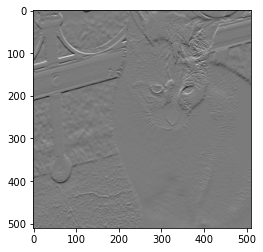

In [14]:
plt.imshow(cat_filter, cmap='gray')    

## Pooling
Pooling is used to decrease the size of the features and so also computations and the degree of overfitting. The most common pooling layers are mean and max pooling. The pooling layer in a CNN does not contain parameters to be learnt. 

## Implementing a CNN
After we have seen what a convolution is, we can see how it can be used in a neural network. We will use images as input for our CNN. We have to take into account that several Python packages use NumPy multidimensional array to handle RGB images. NumPy represents an image in an array of rank [H, W, C] where H is the hight, W the width and C one the RGB channels with red = 0, green = 1, blue = 2.

In [15]:
cat_img = io.imread('images/cat_dog_images/cat-01.jpg')
cat_img.shape

(900, 1200, 3)

PyTorch represent an RGB image as [C, H, W], so the first index in the array is used for the channels.

In [16]:
from torchvision.io import read_image
 
img = read_image('images/cat_dog_images/cat-01.jpg') 
print('Image shape:', img.shape)

Image shape: torch.Size([3, 900, 1200])


The convolution of all the three RGB channels, or more for multispectral images, is simply computed by applying the convolution to each channel and then adding the results by matrix summation. The computation of a convolutional layer where the pixels of an image represent the inputs is performed like in a feedforward layer. After the computation of the convolution we add a bias vector and then we compute the activation. If we represent the convolution of a single channel with $\hat{W_c}\hat{X_c}$ the result of the activation function is a feature map 

$$\hat{A} = \sigma (\sum_c (\hat{W_c}\hat{X_c} + b_c))$$

Usually we want to compute more than one feature map from an image because we think that it contains more than one information. if $m$ x $m$ represents the dimension of the kernel, $c_{in}$ the channels or input features, and $c_{out}$ the number of feature maps, the total number of parameters that have to be learnt, without taking into account the bias, is 
  
$$m  \cdot  m \cdot c_{in} \cdot c_{out}$$

This value is usually significantly smaller than the number of parameters for a fully connected layer

$$(n_h  \cdot n_w  \cdot c_{in}) \cdot (n_h  \cdot n_w  \cdot c_{out}) = (n_h  \cdot n_w)^2 \cdot c_{in} \cdot c_{out}$$

where $n_h$ and $n_w$ are the height and width of the input image.

### Regularization techniques
Regularization techniques are used to prevent overfitting, that is a model that performs well with the training set but is not able to generalize to unseen data. We have already seen the $L_2$ regularization. It adds a quadratic term to the loss function and works similarly to the Lagrange multipliers in an optimization task, by increasing the loss for the largest weights by an amout that is specified by the multiplying factor $\lambda$. 

$$\mathscr{\hat{L}} = \mathscr{L} + \frac{\lambda}{2}||w||^2 = \frac{1}{2} \sum_{i=1}^N|| y - \hat{y_i}||^2 + \frac{\lambda}{2}||w||^2$$ 

so that the gradient descent becomes

$$w_{j+1} = w_j - \gamma (\lambda w_j + \nabla_w{\mathscr{L}}) = (1 - \gamma\lambda)w_j - \gamma\nabla_w{\mathscr{L}}$$

Dropout is a regularization technique that enhances the generalization characteristics of a NN model by randomly removing part of the units at each training cycle (not during validation or inference). 

### Implementing a CNN with PyTorch
We have seen several feedforward neural networks in which the units were fully connected. Now we will implement a convolutional neural networks using the the modules available from PyTorch for the classification of the MNIST handwritten digits. In order to implement a model and train, validate and test it we have to fetch the data, split the dataset into three subsets and build our convolutional neural network.


### Fetching the MNIST daset
We fetch the data from the datasets already available from PyTorch, as we did in [another notebook](pytorch.ipynb#Fetching-available-data-sets). The dataset might already be in the 'data/' folder, if not just set the 'download' attribute to True. The MNIST dataset is split into two subset, one for training with 60k images, and one for testing with 10k images. We use the first 10k images of the training set for validation and the remainng 50k images for training

In [46]:
import torchvision
from torchvision import transforms
from torch.utils.data import Subset

transform = transforms.Compose([transforms.ToTensor()])
dataset_path = 'data/'
mnist_dataset = torchvision.datasets.MNIST(dataset_path, train="True", transform = transform, download=True)
assert isinstance(mnist_dataset, torch.utils.data.Dataset)

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))

len(mnist_train_dataset), len(mnist_valid_dataset)

(50000, 10000)

We fetch the test dataset from PyTorch if it has not yet already been downloaded. We will use the test dataset to check the performances of our model after the training.

In [48]:
mnist_test_dataset = torchvision.datasets.MNIST(root=dataset_path, train=False, transform=transform, download=True)
assert isinstance(mnist_dataset, torch.utils.data.Dataset)
print(mnist_test_dataset)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


### Data loading
We stack the images into batches of 64 images so the dimension of each batch is of the form [N, C, H, W] where N is index of an image within the batch, C the channel index (always 0 in our case), and H and W are the height (row index) and width (column index) of the images. This is the structure that is accepted in PyTorch modules and is different from the structure used in other frameworks such as TensorFlow.

In [49]:
from torch.utils.data import DataLoader

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

### Building the CNN network
Each image in the MNIST dataset has 28x28 pixels with only one channel. We build our CNN model as follows. The first layer is convolutional with a 5x5 kernel that outputs 32 feature maps of the same size 28x28. The 2x2 max-pooling layer after it reduces the size of the input to 14x14. A second convolutional layer with a 5x5 kernel outputs 64 feature maps and the 2x2 max-pooling layer after it reduces the size of the input to 7x7. A first fully connected layer maps the output of the pooling layer to 1000 outputs that are used as the inputs of a second fully connected layer with 10 outputs. The outputs of the 2nd fully connected layer will be used as input to a softmax function to comput the probabilities of an input image to belong to any of the 10 digit classes. The class with highest probability will be assigned to the image.   

<img src="images/cnn_architecture.jpg" alt="cnn" width="900px" height="300" align="center">
The PyTorchh torch.nn module provides all the components we need to build our convolutional neural network: 

* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), a 2D convolutional layer 
* [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), a 2D max-pooling subsampling layer
* [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html), for regularization

The fully connected layer is implemented, as  we have seen before, as a linear layer and an activation function. We use a Sequential container to add the layers to our model as shown in the picture.

In [37]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

We can see the dimensions of the output tensor of our model, after the 2nd max-pooling layer, by passing a tensor that contains a batch like those that we will use: 64 tensors of 64 feature maps with a spatial size of 7x7. As we can see network behaves as an encoder by extracting as much relevant information, that is feature maps, as possible from the images. The network should learn a representation of the data reducing its spatial dimensions, in our case from 28x28 to 7x7. 

In [38]:
x = torch.ones((64, 1, 28, 28))
model(x).shape

torch.Size([64, 64, 7, 7])

In order to add the fully connected layer we have to flatten the shape of the output tensor

In [39]:
model.add_module('flatten', nn.Flatten())
model(x).shape

torch.Size([64, 3136])

After that we can add the fully connected layer with the dropout regularization, with drop probability p=0.5, and then the final fully connected layer with 10 output units that will be used to compute the probabilities for each digit class. 

In [40]:
model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 
model.add_module('fc2', nn.Linear(1024, 10)) 

We use the cross entropy loss function and the the Adam optimizer for our classification task. The cross entropy loss works like the logistic regression loss function for binary classification but for a multiclass classification task.

In [53]:
#loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

We define the training loop

In [54]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            #x_batch = x_batch.to(device) 
            #y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                #x_batch = x_batch.to(device) 
                #y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

Finally we start the training. We collect the data about the performance of the network for each of the epoch using the classification accuracy as a metric with the training set and the validation set.

In [55]:
#device = torch.device("cuda:0")
#model = model.to(device) 
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9881 val_accuracy: 0.9794
Epoch 2 accuracy: 0.9872 val_accuracy: 0.9886
Epoch 3 accuracy: 0.9917 val_accuracy: 0.9865
Epoch 4 accuracy: 0.9937 val_accuracy: 0.9890
Epoch 5 accuracy: 0.9945 val_accuracy: 0.9889
Epoch 6 accuracy: 0.9959 val_accuracy: 0.9894
Epoch 7 accuracy: 0.9964 val_accuracy: 0.9878
Epoch 8 accuracy: 0.9964 val_accuracy: 0.9900
Epoch 9 accuracy: 0.9973 val_accuracy: 0.9869
Epoch 10 accuracy: 0.9969 val_accuracy: 0.9910
Epoch 11 accuracy: 0.9976 val_accuracy: 0.9909
Epoch 12 accuracy: 0.9979 val_accuracy: 0.9900
Epoch 13 accuracy: 0.9978 val_accuracy: 0.9893
Epoch 14 accuracy: 0.9981 val_accuracy: 0.9906
Epoch 15 accuracy: 0.9978 val_accuracy: 0.9899
Epoch 16 accuracy: 0.9982 val_accuracy: 0.9918
Epoch 17 accuracy: 0.9986 val_accuracy: 0.9887
Epoch 18 accuracy: 0.9976 val_accuracy: 0.9891
Epoch 19 accuracy: 0.9982 val_accuracy: 0.9912
Epoch 20 accuracy: 0.9985 val_accuracy: 0.9892


We can plot the loss and the accuracy at each epoch for the training set and the validation set.

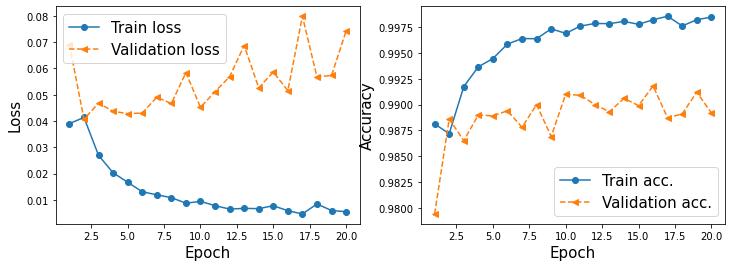

In [56]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

As a final test we compute the accuracy for the test set, a set of 10k images that was never used for the training.

In [57]:
#torch.cuda.synchronize()
#model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9911


Now we can see the inference performance of our network on some images from the test set.

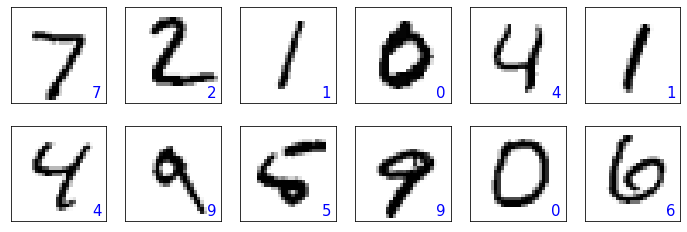

In [58]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
plt.show()